In [1]:
from pathlib import Path

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.vision.data import *

In [4]:
path = Path("dataset_segmentation_small/")
path_lbl = path / "labels"
path_img = path / "images"

In [5]:
get_labels = lambda x: path_lbl / x.name
codes = np.array(['background','fruit'], dtype='str'); codes       

array(['background', 'fruit'], dtype='<U10')

In [6]:
fnames = get_image_files(path_img/ "train")
mnames = get_image_files(path_lbl)

In [7]:
m = open_mask(mnames[0])

In [8]:
np.unique(m.data)

array([  0, 255])

In [9]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['background','fruit']

In [10]:
#src_size = np.array(open_image(fnames[0]).shape[1:]) #get sample shape, need to change this for full dataset
size = 256
bs=8


In [11]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [12]:
inf_size = 400

In [13]:
inf_data =  (SegItemListCustom.from_folder(path_img)
            .split_by_folder(train='train', valid='valid')
            .label_from_func(get_labels, classes=codes)
            .transform(size=inf_size, tfm_y=True, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [14]:
inf_learn = unet_learner(inf_data, models.resnet34, metrics=[seg_accuracy]).load("test1-10epoch-256")

In [15]:
def seg_test_image(img, real_mask):
    pred_mask, _, _ = inf_learn.predict(open_image(img))
    real_mask = open_mask(real_mask, div=True).apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
    wrong = np.count_nonzero(pred_mask.data != real_mask.data)
    
    intersection = np.logical_and(real_mask.data, pred_mask.data)
    union = np.logical_or(real_mask.data, pred_mask.data)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [16]:
iou_score, wrong = seg_test_image(fnames[0], get_labels(fnames[0]))

In [17]:
type(iou_score)

torch.Tensor

In [18]:
#warning works only with square inf_size
def seg_bench_test():
    imgs = get_image_files(path_img / "final_test")
    masks = [get_labels(f) for f in imgs]
    wrongs = torch.empty(len(imgs), dtype=torch.float32)
    iou_scores = torch.empty(len(imgs), dtype=torch.float32)
    for i, img, mask in zip(range(len(imgs)), imgs, masks):
        iou_score, wrong = seg_test_image(img, mask)
        wrongs[i] = wrong
        iou_scores[i] = iou_score
                            
    wrong_perc = torch.mean(wrongs) * 100 / inf_size**2
    print(f"perc of wrong pixels: {wrong_perc}%")
    print(f"mean accuracy: {100-wrong_perc}%")
    print(f"max wrong per image: {torch.max(wrongs)} over {inf_size**2} pixels")
    print(f"mean IoU: {torch.mean(iou_scores)}")
    print(f"min IoU: {torch.min(iou_scores)}")

In [ ]:
seg_bench_test()

In [27]:
def plot_pixel_difference(img_path, real_mask_path, figsize=(20,20)):
    img = open_image(img_path)
    pred_mask, _, _ = inf_learn.predict(img)
    real_mask = open_mask(real_mask_path, div=True).apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
    real_mask = image2np(real_mask.data)
    pred_mask = image2np(pred_mask.data)

    img = img.apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
    img = image2np(img.data)
    diff = pred_mask != real_mask
    img[diff==1] = (0, 0 ,1) # 0000FF is blue
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

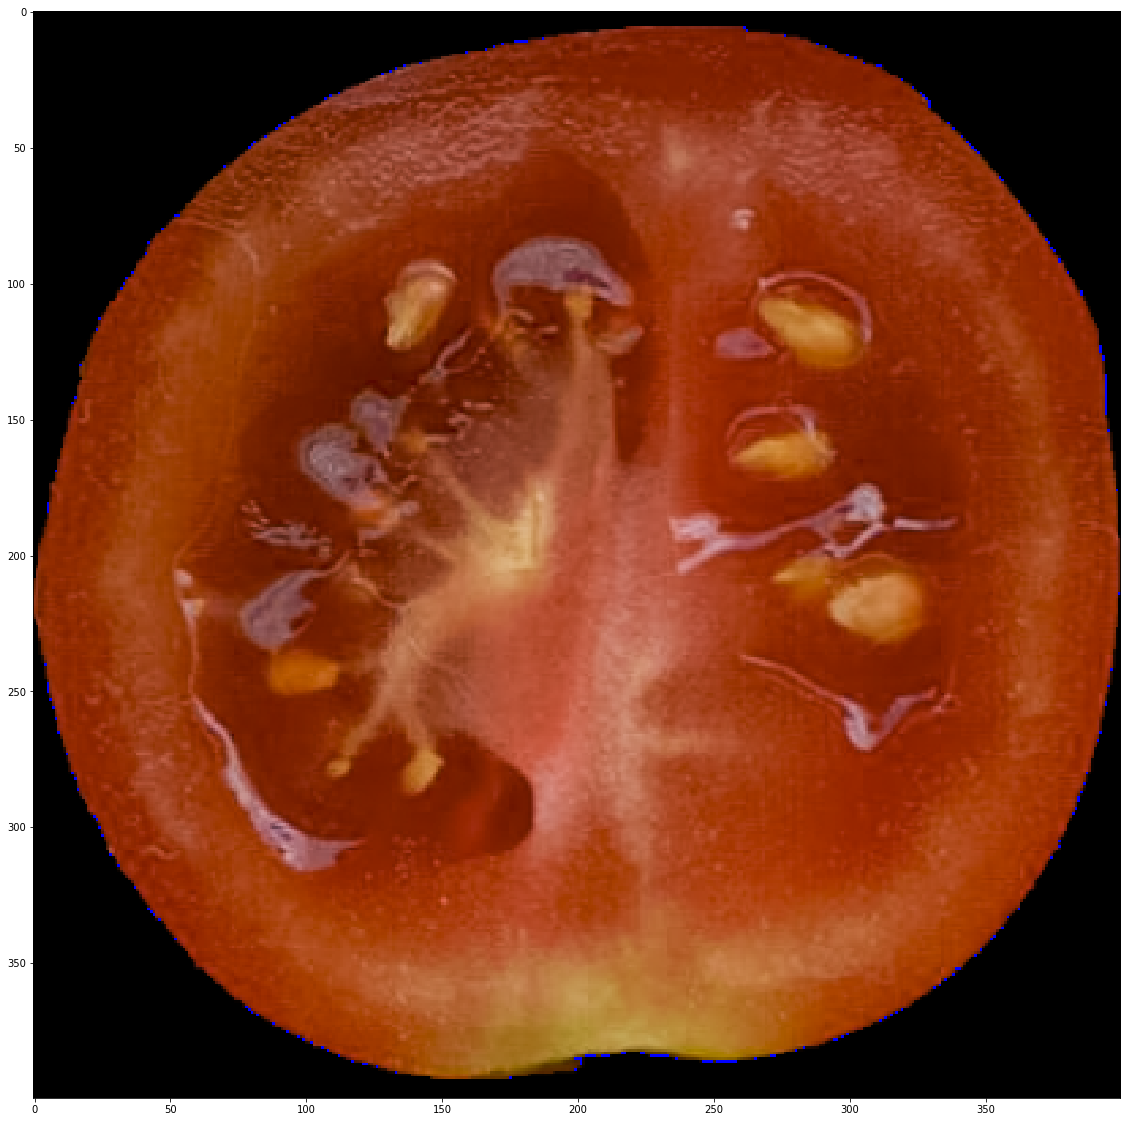

In [29]:
plot_pixel_difference(fnames[20], get_labels(fnames[20]))

In [102]:
img[diff==1] = (0, 0 ,1) # 0000FF is blue

In [11]:
inf_size = 256

In [12]:
inf_data =  (SegItemListCustom.from_folder(path_img)
            .split_by_folder(train='train', valid='valid')
            .label_from_func(get_labels, classes=codes)
            .transform(size=inf_size, tfm_y=True, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [13]:
inf_learn = unet_learner(inf_data, models.resnet34, metrics=[seg_accuracy]).load("test1-10epoch-256")

In [18]:
def seg_test_image(img, real_mask):
    pred_mask, _, _ = inf_learn.predict(open_image(img))
    real_mask = open_mask(real_mask, div=True).apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
    wrong = np.count_nonzero(pred_mask.data != real_mask.data)
    
    intersection = np.logical_and(real_mask.data, pred_mask.data)
    union = np.logical_or(real_mask.data, pred_mask.data)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [20]:
iou_score, wrong = seg_test_image(fnames[0], get_labels(fnames[0]))

In [24]:
type(iou_score)

torch.Tensor

In [27]:
#warning works only with square inf_size
def seg_bench_test():
    imgs = get_image_files(path_img / "final_test")
    masks = [get_labels(f) for f in imgs]
    wrongs = torch.empty(len(imgs), dtype=torch.float32)
    iou_scores = torch.empty(len(imgs), dtype=torch.float32)
    for i, img, mask in zip(range(len(imgs)), imgs, masks):
        iou_score, wrong = seg_test_image(img, mask)
        wrongs[i] = wrong
        iou_scores[i] = iou_score
                            
    wrong_perc = torch.mean(wrongs) * 100 / inf_size**2
    print(f"perc of wrong pixels: {wrong_perc}%")
    print(f"mean accuracy: {100-wrong_perc}%")
    print(f"max wrong per image: {torch.max(wrongs)} over {inf_size**2} pixels")
    print(f"mean IoU: {torch.mean(iou_scores)}")
    print(f"min IoU: {torch.min(iou_scores)}")

In [28]:
seg_bench_test()

perc of wrong pixels: 0.17860011756420135%
mean accuracy: 99.82140350341797%
max wrong per image: 232.0 over 65536 pixels
mean IoU: 0.9972500205039978
max IoU: 0.9996857047080994


In [ ]:
#def plot_pixel_difference(img, real_mask):
pred_mask, _, _ = inf_learn.predict(open_image(img))
real_mask = open_mask(real_mask, div=True).apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
diff = pred_mask.data != real_mask.data


## training

In [ ]:
src = (SegItemListCustom.from_folder(path_img)
       .split_by_folder()
       .label_from_func(get_labels, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.classes

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=seg_accuracy)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, 5e-5)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.show_results()

In [ ]:
learn.export()

In [ ]:
#learn.save('stage-1-256-small_images')

In [ ]:
inf_learn = load_learner(path/"images")

In [ ]:
preds,y,losses = inf_learn.predict(open_image("dataset_segmentation_small/images/final_test/Albicocca_100.png"))

In [ ]:
preds

In [ ]:
act_mask = open_mask(get_labels(Path("dataset_segmentation_small/images/final_test/Albicocca_100.png")))

In [ ]:
act_mask.resize(256)

In [ ]:
learn.save("test1-10epoch-256")

In [ ]:
inf_data =  (SegItemListCustom.from_folder(path_img)
            .split_by_folder(train='train', valid='valid')
            .label_from_func(get_labels, classes=codes)
            .transform(size=256, tfm_y=True, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [ ]:
inf_learn = unet_learner(inf_data, models.resnet34, metrics=[seg_accuracy]).load("test1-10epoch-256")

In [ ]:
pred, _, _ = inf_learn.predict(open_image("dataset_segmentation_small/images/train/Albicocca_18.png"))

In [ ]:
pred
mask_path = get_labels(Path("dataset_segmentation_small/images/train/Albicocca_18.png"))
mask = open_mask(mask_path, div=True).apply_tfms([],size=256, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')

In [ ]:
wrong = np.count_nonzero(pred.data != mask.data)
tot = np.prod(pred.shape)
wrong, tot, wrong/tot *100

In [ ]:
np.count_nonzero(pred.data == mask.data) / size**2

In [ ]:
learn.validate(inf_data.valid_dl, metrics=[seg_accuracy])

In [ ]:
i = open_image("dataset_segmentation_small/images/train/Albicocca_18.png")
i.resize??

In [ ]:
open_image("dataset_segmentation_small/images/train/Albicocca_18.png").resize

per applicare le stesse transformazioni anche a mano:`image.apply_tfms([],size=256, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')`

In [ ]:
learn.predict(open_image)

In [ ]:
learn.show_results()

In [ ]:
pred , _, _ = learn.predict(inf_data.valid_ds[100][0])
pred

In [ ]:
inf_data

In [ ]:
img = data.train_ds[80][0]
path_img = Path('dataset_segmentation_small/images/train/Albicocca_5.png')
#img = open_image(path_img)
pred_mask = learn.predict(img)[0]
# pred_mask_data = pred_mask.data * 255 #to convert back after div=True
# actl_mask = open_mask(path_img).resize(size)
# np.count_nonzero(pred_mask==actl_mask)

pred_mask.save('mask_test.png')
img.show(y=pred_mask)

In [ ]:
mask.show(figsize=(5, 5), alpha=1)